<a name='0'></a>

# ResNeXt - Aggregated Residual Transformations for Deep Neural Networks


What's in here:

* [Introdution](#1)
* [The Notion of Aggregated Transformation](#2)
* [ResNeXt Architecture](#3)
* [ResNeXt implementation](#4)
* [Final Notes](#5)
* [Reference Implementations](#6)

<a name='1'></a>

## 1. Introduction

[ResNeXt](https://arxiv.org/abs/1611.05431) is an improved or modularized version of ResNet that achieved a second place in ImageNet Classification Challenge 2016. ResNeXt draws an inspiration from VGG & ResNet that has similar repeating blocks of the same shape.

ResNeXt have a simple design yet high accuracy and low complexity than standard ResNet and Inception V3. It follows the following design rules:

- The residual blocks that produces the spatial maps of the same size should have the same width and filter sizes.

- Everytime the spatial map is downsampled by a factor of 2, the width of the residual block is also multiplied by a factor of 2. This idea preserves the same computational complexity in terms of FLOPS(floaping point operations).


To improves the performance while maintaining low computational complexity, ResNeXt makes use of `grouped convolutions`. Grouped convolutions are special kind of convolutions where the input and output channels are divided into parallel groups, and convolutions are separately computed within each group and the results are concatenated. If the number of groups are equal to the number of channels, such grouped convolutions are called `depth-wise convolution`. A depth-wise convolution followed by 1x1 or pointwise convolution is called `depth-wise separable convolution`.



<a name='2'></a>

## 2. The Notion of Aggregated Transformation

In essence, convolutional layer(and fully connected layer) computes inner product(weighted sum) of filter's weights $W$ and input image vector $X$ over the total numbers of the input channels $D$

$$\sum_{i=1}^D WiXi$$

The above equation can be seen in 3 steps:

- **Splitting**: Dividing vector `X` into single dimension subspaces($X1, X2, X3....XD$)

- **Transformation**: Transforming and scaling every single dimension subspace: $WiXi$.

- **Aggregating**: Summing/aggregating all transformations, $\sum_{i=1}^D WiXi$

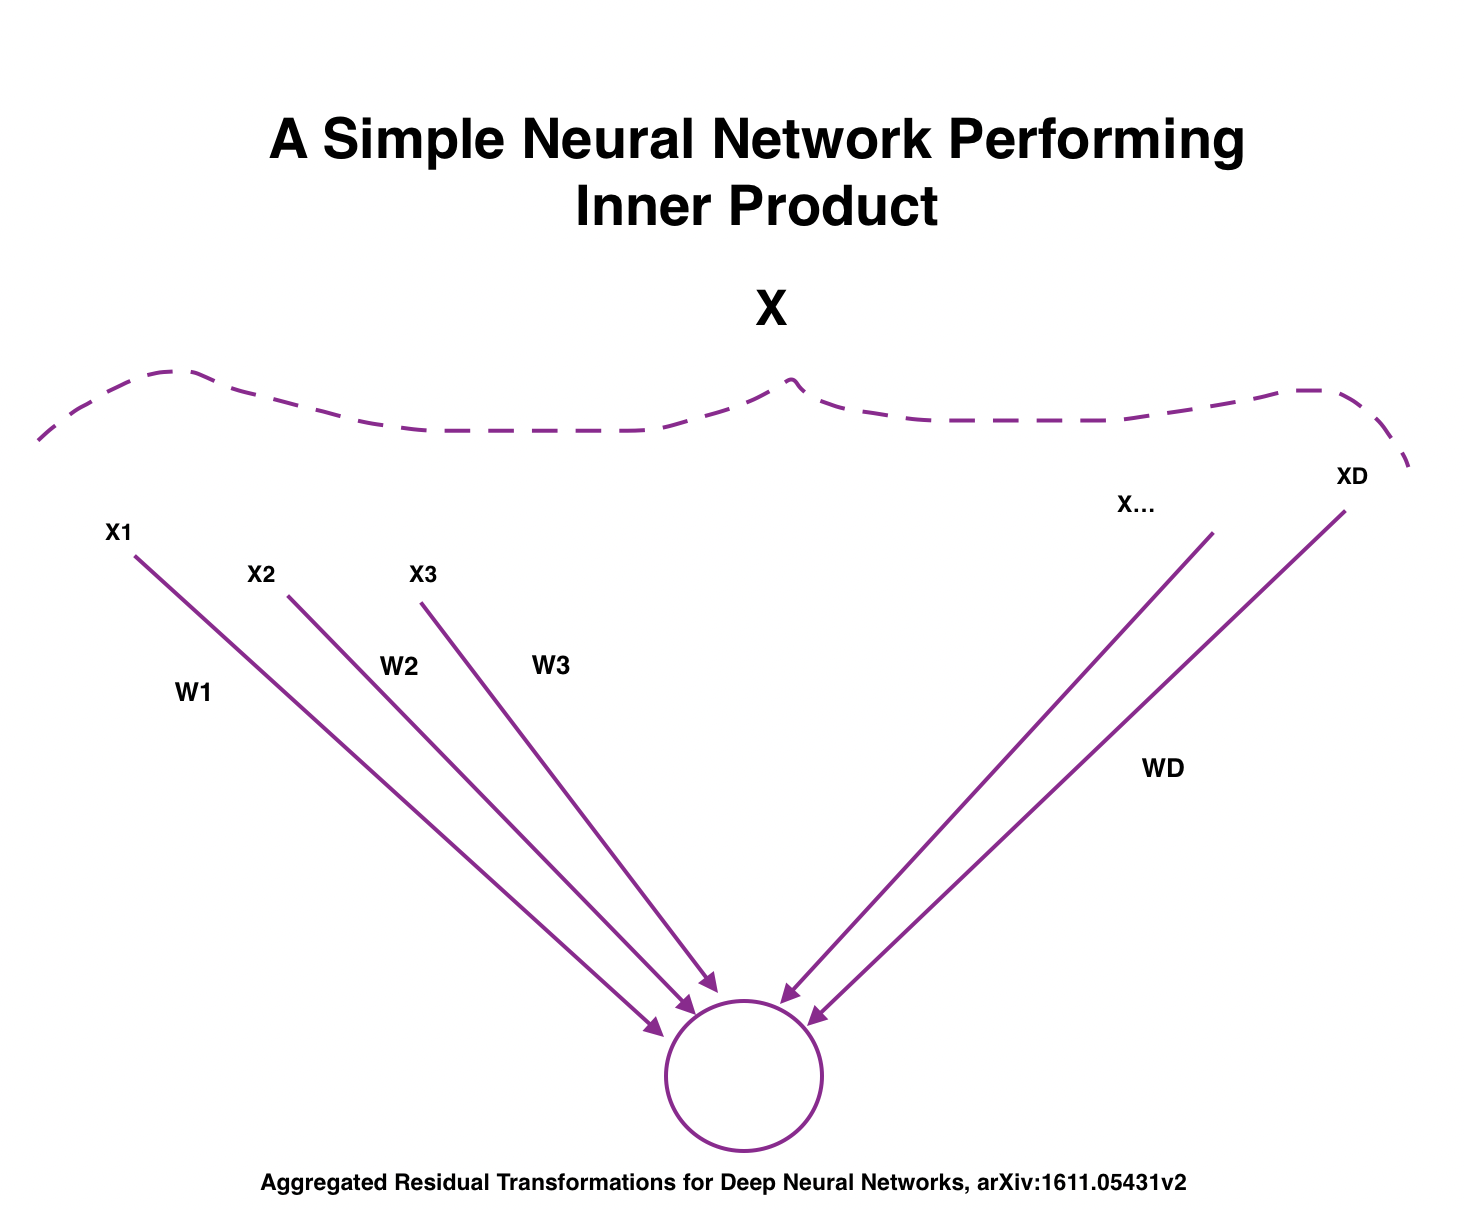

The above simple aggregation transformation $\sum_{i=1}^D WiXi$ can be generalized into a function $Ti(x)$ that can also serve as a residual aggregated transformation(See the image below a), the term $x$ represents direct shortcut connection):

$$y = x + \sum_{i=1}^D Ti(x)$$

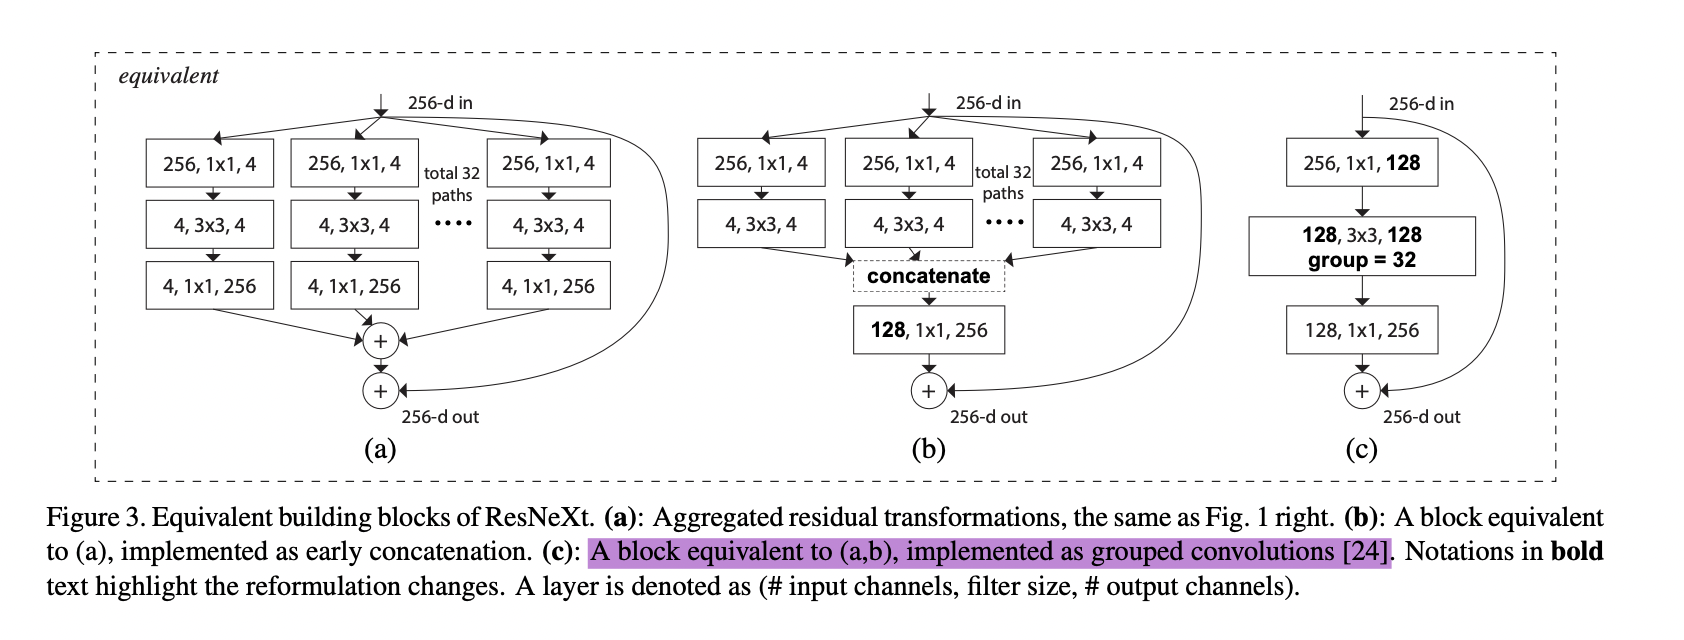

The above was the idea behind the name of the paper **Aggregated Residual Transformations for Deep Neural Networks**. The special thing about ResNeXt residual blocks is they it has the same topology(same size) over the whole network(VGG-like style) and to simplify the blocks, it uses grouped convolutions. You can see in the above image that either a, b, and c ResNeXt blocks are equivalent, but c is simple due to grouped convolutions(splitting the input channels in parallel groups). 

The paper uses `C` to represent the size of the set of aggregated transformations or `cardinality`, or simply the number of groups in the grouped convolution.

<a name='3'></a>

## 3. ResNeXt Architecture

The main building block of ResNeXt is the residual block that has the same topology over the whole network. 

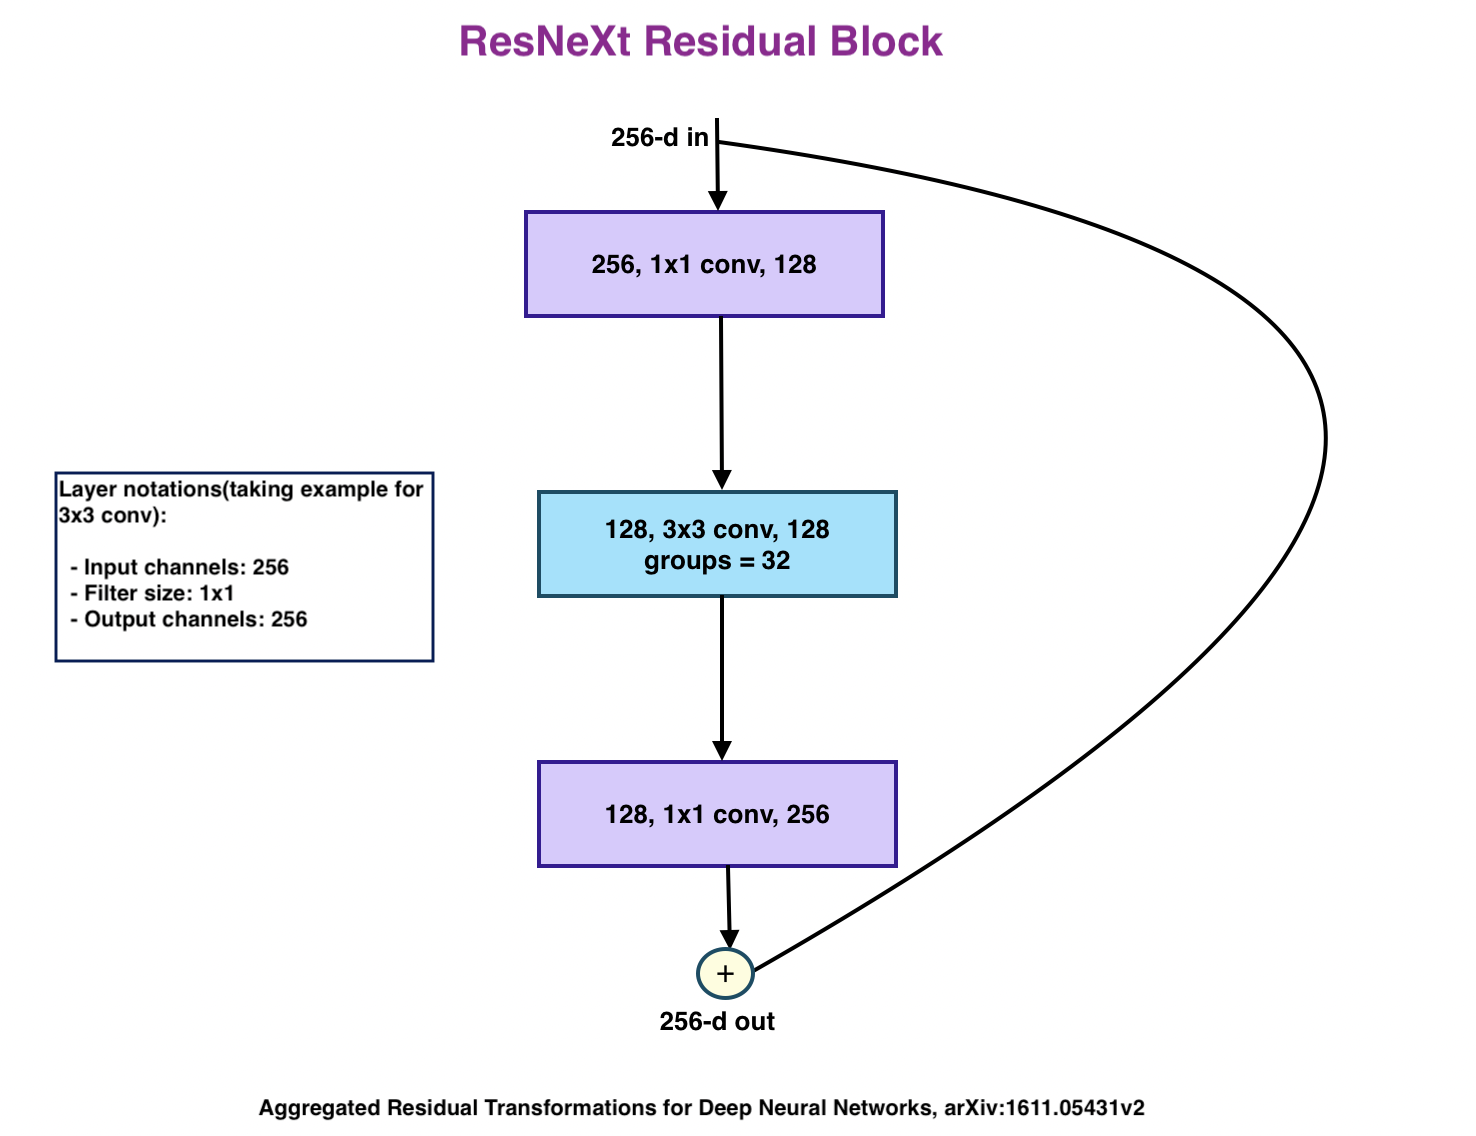

ResNeXt residual block starts with 1x1 conv layer followed by 3x3 conv layer followed by 1x1 conv layer. The 3x3 conv layer uses grouped convolution with groups of 32 for all 4 stages. In standard ResNeXt-50(comparable to ResNet-50), there are 4 stages whose residual blocks are `(3,4,6,3)` respectively.


All residual blocks have identity(or direct) shortcut connections, but since identity shortcuts are only applicable when the input and output of block are of same dimension(otherwise, they can't be added), we use projection shortcuts at the very first block of each stage. Projections shortcuts uses 1x1 conv in the shortcut connection.


The stem of ResNeXt(or the initial part of the network) is made of 7x7 conv layer with strides of 2 and 3x3 maxpool with strides of 2. This stem also acts as input downsampler.

The network ends with global average pooling layer and fully connected layer of 1000 units for classification purpose. 1000 units in final fully connected layer is per ImageNet 1000 classes.

All convolution layers are followed by batch normalization layer and ReLU activation layer except at the last 1x1 conv in residual block that doesn't have ReLU layer. ReLU is instead applied to the total output of the block.

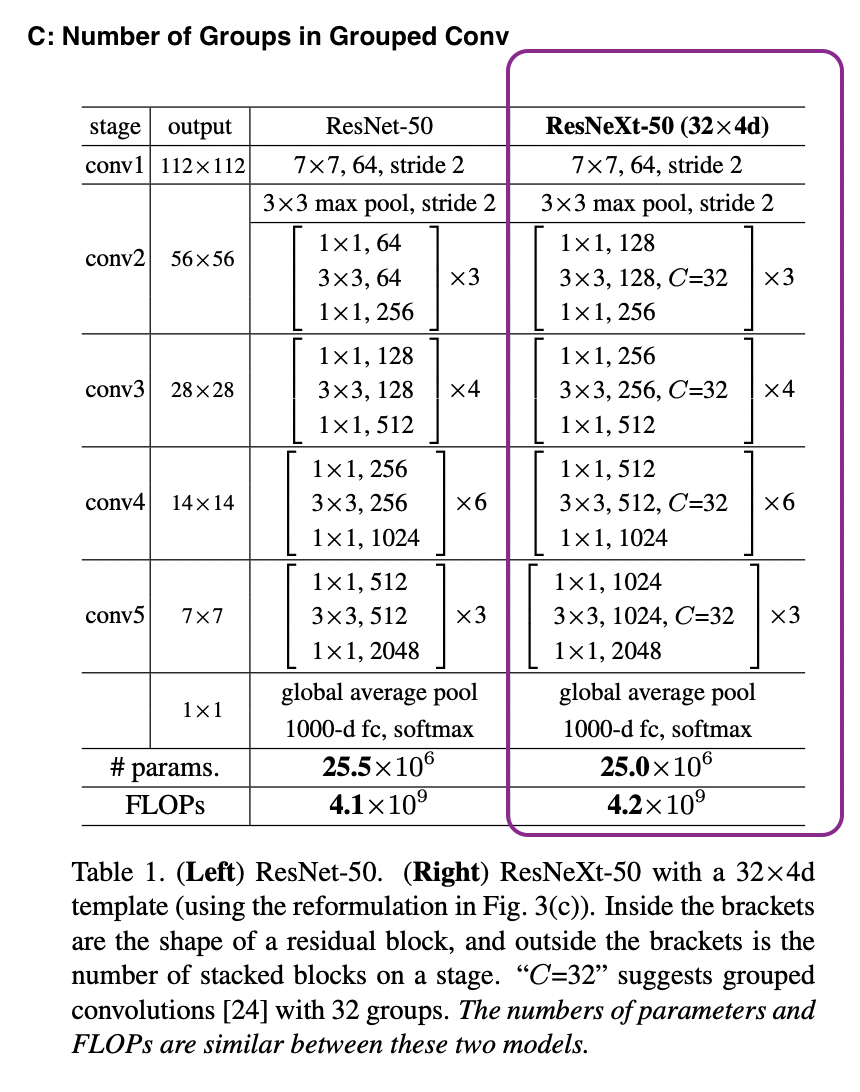

<a name='4'></a>

## 4. Implementing ResNeXt

### Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Identity Block

We will start implementing the identity block. Identity blocks are used when the input and output shape of a given residual block are similar.

In [ ]:
def identity_block(input, dim):
  """
  input: input tensor
  dim: channel dimension of conv_layers
  """
  
  shortcut = input

  x = layers.Conv2D(filters=dim, kernel_size=1)(input)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filters=dim, kernel_size=3, groups=32, padding='same')(input)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filters=dim*2, kernel_size=1)(x)
  x = layers.BatchNormalization()(x)

  output = layers.Add()([shortcut, x])
  output = layers.Activation('relu')(output)

  return output

### Projection Block

Projection blocks are used when the input shape and the output shape of the residual block are different. They are typically inserted at the very first block of the residual stages and are merely for increasing the dimension.



In [ ]:
def projection_block(input, dim, strides=1):
  """
  input: input tensor
  dim: channel dimension of conv_layers
  strides: strides = 2 for conv3, conv4, conv5

  projection block has 1x1 conv in the shortcut connection.
  """
  
  shortcut = layers.Conv2D(filters=2*dim, kernel_size=1, strides=strides)(input)
  shortcut = layers.BatchNormalization()(shortcut)

  x = layers.Conv2D(filters=dim, kernel_size=1)(input)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filters=dim, kernel_size=3, strides=strides, groups=32, padding='same')(input)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filters=dim*2, kernel_size=1)(x)
  x = layers.BatchNormalization()(x)

  output = layers.Add()([shortcut, x])
  output = layers.Activation('relu')(output)

  return output

### Building the Rest of the Architecture

In [ ]:
input = layers.Input(shape=(224, 224, 3))

# stem
x = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same')(input)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

# Stage 1, 3 blocks
x = projection_block(x, 128)

for _ in range(2):
  x = identity_block(x, 128)

# Stage 2, 4 blocks
x = projection_block(x, 256, 2)
for _ in range(4):
  x = identity_block(x, 256)

# Stage 3, 6 blocks
x = projection_block(x, 512, 2)
for _ in range(6):
  x = identity_block(x, 512)

# Stage 4, 3 blocks
x = projection_block(x, 1024, 2)
for _ in range(3):
  x = identity_block(x, 1024)

# classification head
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(units=1000, activation='softmax')(x)


resnext = keras.Model(input, output, name='ResNeXt-50')

Let's check the summary of the model we just built.

In [ ]:
resnext.summary()

Model: "ResNeXt-50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_517 (Conv2D)            (None, 112, 112, 64  9472        ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_517 (Batch  (None, 112, 112, 64  256        ['conv2d_517[0][0]']             
 Normalization)                 )                                                        

We can also plot using Keras model plotting util. 

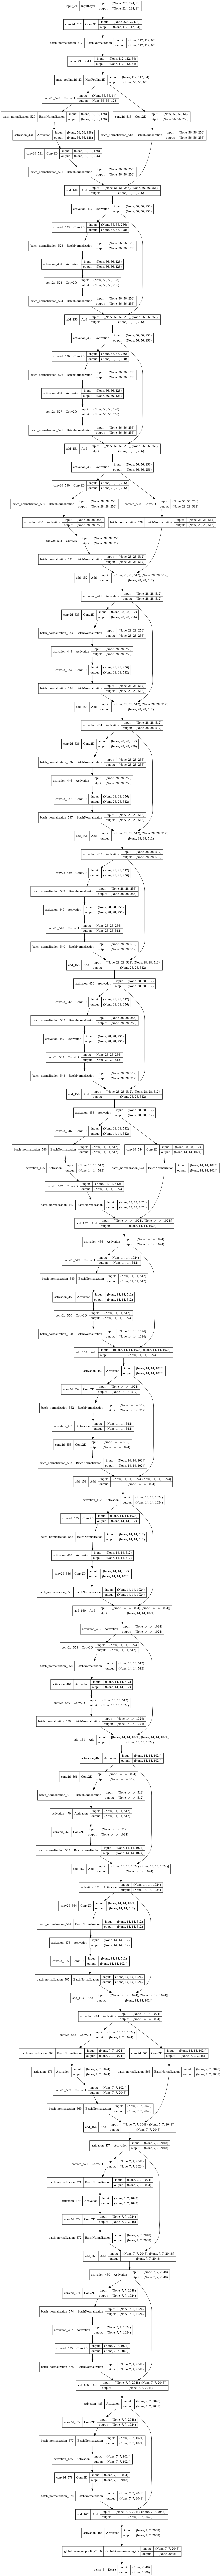

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(resnext, show_shapes=True)

<a name='5'></a>

## 5. Final Notes

ResNeXt is a modularized version of ResNet. The special thing about ResNeXt is that it uses grouped convolutions in residual blocks(relating aggregated transformations).

Below is the comparison of ResNet and ResNeXt on ImageNet-1K. As you can see, ResNeXt beats ResNet by all means!!



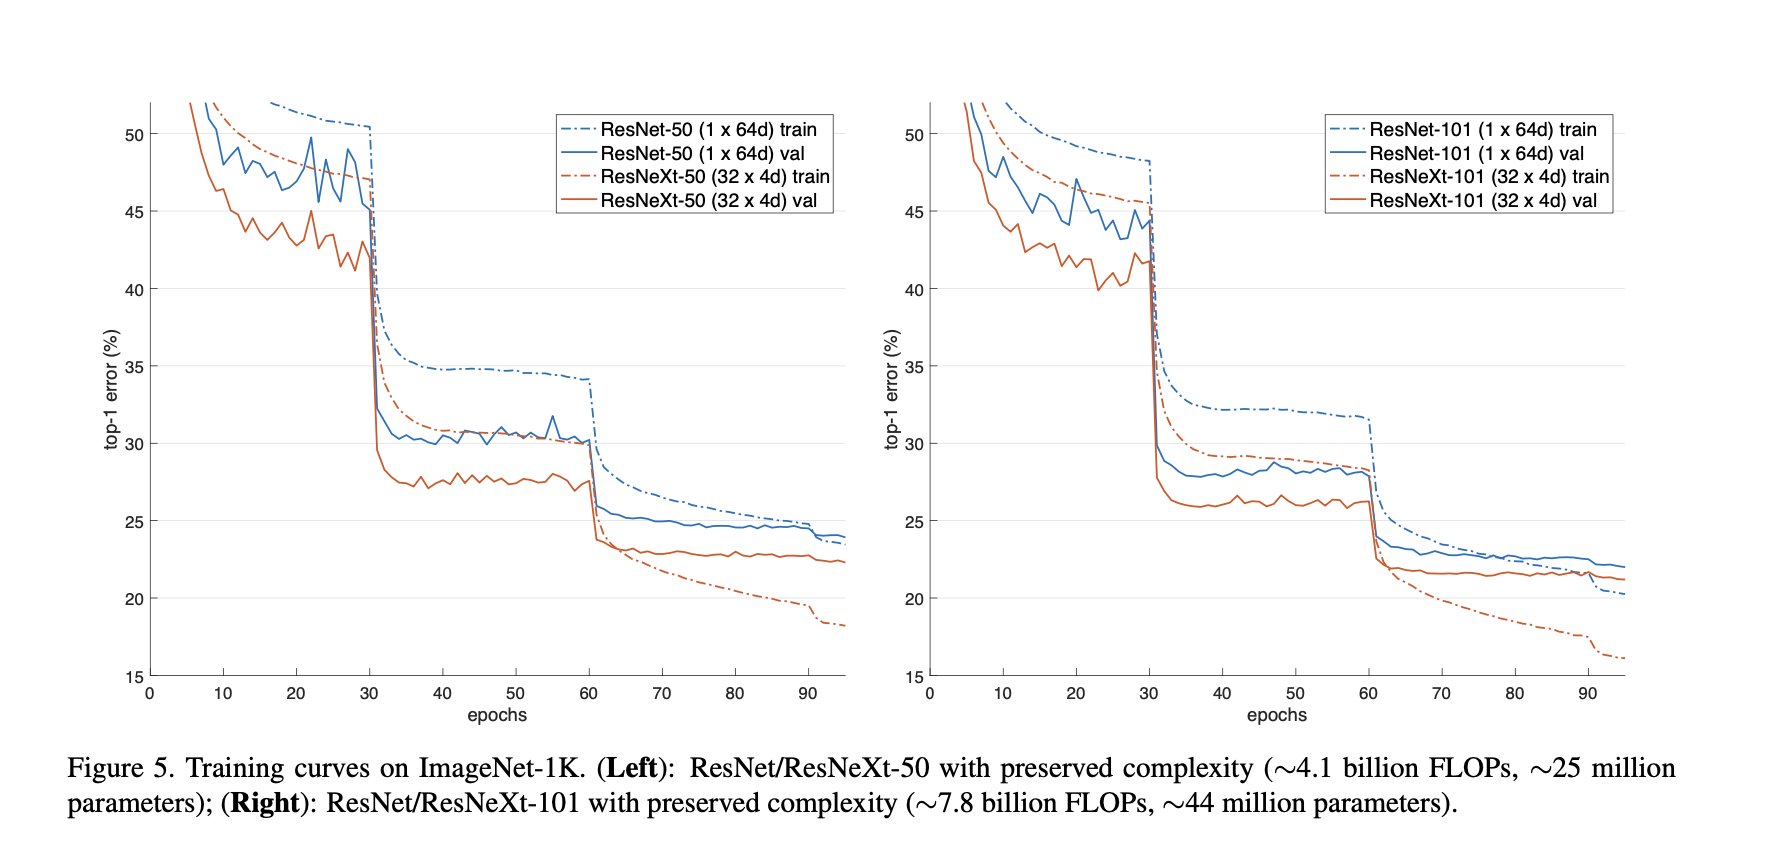

As the authors experimented and reported, residual connections improves optimization whereas aggregated transformations are stronger representations. Training ResNet-50 yielded 23.9% error rate with residual connections and 31.2% without residual connections, whereas ResNeXt-50 achieved error rate of 22.2% and 26.1% respectively. Without the residual connections, the difference between 31.2% and 26.1% is pretty huge!!

<a name='6'></a>

## 6. Reference Implementation

* [PyTorch Vision](https://github.com/pytorch/vision/blob/5a315453da5089d66de94604ea49334a66552524/torchvision/models/resnet.py#L328)
* [Timm Models by Ross Wightman](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/rexnet.py)

### [BACK TO TOP](#0)